<a href="https://colab.research.google.com/github/aregawihalefom/Deep-Learning-Models/blob/master/MNIST_CLASSIFIER_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data.dataloader as dataloader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.optim as opt
import torch.nn as nn
import torch.optim as optim


In [2]:
# check if there is GPU
gpu_avaliable = torch.cuda.is_available()
if gpu_avaliable:
  device = "cuda"
  print("GPU avaliable train of GPU")
else:
  print("No GPU availabie , training will continue on cpu")

GPU avaliable train of GPU


In [3]:
# Prepare dataset
ts = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.4 , 0.5)])
train = datasets.MNIST('mnist', train=True, transform=ts, download=True)
test  = datasets.MNIST('mnist', train=False, transform=ts, download=True)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = dataloader.DataLoader(train,batch_size=64 , shuffle=True)
test_loader = dataloader.DataLoader(test,batch_size=64 , shuffle=False)

In [5]:
# VISUALIZATION

(-0.5, 27.5, 27.5, -0.5)

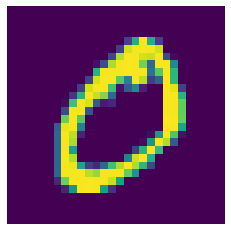

In [6]:
# single image
fig = plt.figure()
plt.imshow(train.data[1,:,:])
plt.axis('off')

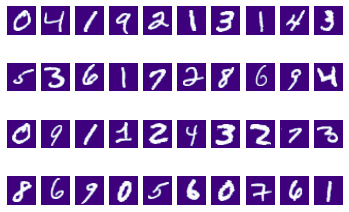

In [7]:
# multiple images
fig = plt.figure()
num_image = 40 
for i in range(1 , 41):
  plt.subplot(4,10,i)
  plt.imshow(train.data[i],cmap='Purples_r' , )
  plt.axis('off')

In [8]:
# Creating Network Architecture
class Network(nn.Module):
  def __init__(self , num_in_channels, num_classes):
    super(Network, self).__init__()

    self.features = nn.Sequential(
           nn.Conv2d(num_in_channels, out_channels=32, kernel_size=3 , padding=1 , stride=1),
           nn.ReLU(),

           nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Dropout(0.4),

           nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
           nn.ReLU(),
           nn.MaxPool2d(2)

     )
    self.classfier = nn.Sequential(
       nn.Linear(7*7*64, 200),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(200,num_classes),
       nn.ReLU()
    )
    
  def forward(self, x):

     # extract features
     x = self.features(x)

     # flatten features
     x = x.view(-1 , 7*7*64)

     # classfier part
     x = self.classfier(x)
     
     return x

In [9]:
# Create the instance of the model
model = Network(1,10)
if gpu_avaliable:
  model = model.to(device)

In [10]:
# we will save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [11]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [12]:


#Loss function 
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.Adam(model.parameters() , lr=3e-4 , weight_decay=0.001)


In [13]:
# define training for epoch

def train_one_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_loader:
        # Move the training data to the GPU
        if gpu_avaliable:
           batch = batch.to(device)
           targets = targets.to(device)

        #reset gradients
        optimizer.zero_grad()

        # make prediction ( forward pass)
        predictions = model(batch)

        # calculate loss
        loss = criterion(predictions, targets)

        #backprop
        loss.backward()

        #Update weights
        optimizer.step()

        # hold losses
        train_losses.append(loss.item())
    return np.mean(train_losses)

def testing_one_epoch():

  # put model to validation
  model.eval()

  # validation loos
  test_losses = []
  y_pred = []

  # testing stage
  with torch.no_grad():

    # for each batch
    
    for batch , targets in test_loader:

      # add to device if there is special device
      if gpu_avaliable:
        batch = batch.to(device)
        targets = targets.to(device)


      # make prediction
      predictions = model(batch)

      # calculate the loss
      loss = criterion(predictions,targets)

      # update running loss value
      test_losses.append(loss.item())

      # save predictions
      y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

  # avearage testing error for this
  test_loss = np.mean(test_losses)

  # for accuracy ( we need y_hat and y_true)
  y_hat = np.array(y_pred , dtype = np.float32)
  y_true = np.array(test.targets , dtype=np.float32) # all targets
 
  # get accuracy
  accuracy =  np.mean(y_hat == y_true)

  return test_loss , accuracy

In [14]:
# now iterate through all the epoches
def train_model(epochs):

  train_losses, valid_losses , accuracy = [],  [], []
  for epoch in range(epochs):

    # call training
    train_loss = train_one_epoch()

    # call testing after each epoch
    test_loss, acc = testing_one_epoch()

    print(f'[{epoch:03d}] train loss :{train_loss:04f} '
          f'test loss : {test_loss:04f} '
          f'acc: {acc*100:.2f}%')
    
    # track losses for later statestics
    train_losses.append(train_loss)
    valid_losses.append(test_loss)
    accuracy.append(acc)

    # save models
    check_point_name = f'checkpoints/mnist-{epoch:02d}.pkl'
    save_checkpoint(optimizer,model,epoch,check_point_name)

  return train_losses, valid_losses, accuracy
  

In [15]:
train_losses, valid_losses, acc = train_model(15)

[000] train loss :0.499221 test loss : 0.089832 acc: 97.17%
[001] train loss :0.141576 test loss : 0.053224 acc: 98.18%
[002] train loss :0.101678 test loss : 0.041913 acc: 98.57%
[003] train loss :0.087457 test loss : 0.036429 acc: 98.78%
[004] train loss :0.075598 test loss : 0.032247 acc: 98.85%
[005] train loss :0.070586 test loss : 0.028866 acc: 99.02%
[006] train loss :0.064453 test loss : 0.031521 acc: 98.90%
[007] train loss :0.060565 test loss : 0.027866 acc: 98.99%
[008] train loss :0.054567 test loss : 0.025009 acc: 99.07%
[009] train loss :0.052994 test loss : 0.029018 acc: 98.97%
[010] train loss :0.050455 test loss : 0.024151 acc: 99.21%
[011] train loss :0.048974 test loss : 0.025799 acc: 99.14%
[012] train loss :0.047487 test loss : 0.026082 acc: 99.11%
[013] train loss :0.045417 test loss : 0.023803 acc: 99.18%
[014] train loss :0.044294 test loss : 0.023210 acc: 99.21%


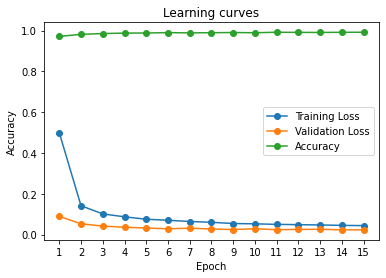

In [16]:
# draw statistics
epochs = range(1,len(train_losses)+1)
fig = plt.figure()
plt.plot(epochs, train_losses ,'-o' , label = "Training Loss")
plt.plot(epochs, valid_losses, '-o' ,label = 'Validation Loss')
plt.plot(epochs, acc, '-o' ,label = 'Accuracy')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.show()


In [17]:
load_checkpoint(optimizer,model,'checkpoints/mnist-14.pkl')

14

In [18]:
# prediction on signle image

image_index = 300 # from the testing set
single_loaded_img = test_loader.dataset.data[image_index]
single_loaded_img = single_loaded_img.to(device)
single_loaded_img = single_loaded_img[None, None]
single_loaded_img = single_loaded_img.type('torch.cuda.FloatTensor') # instead of DoubleTensor

out_predict = model(single_loaded_img)

tensor([[   0.0000,  499.7369,  187.0115,    0.0000, 1233.7959,    0.0000,
          146.5242,  185.9508,    0.0000,    0.0000]], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([[4]], device='cuda:0')


<function matplotlib.pyplot.show>

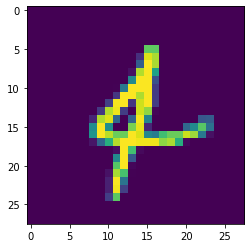

In [19]:
print(out_predict)
pred = out_predict.max(1, keepdim=True)[1]
print(pred)
plt.imshow(test_loader.dataset.data[image_index])
plt.show